# Ensemble


---



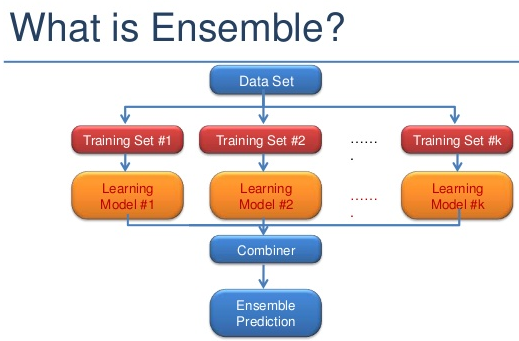

Ensembles can give you a boost in accuracy on your dataset.


---

Combine Model Predictions Into Ensemble Predictions
The three most popular methods for combining the predictions from different models are:

* Bagging: Building multiple models (typically of the same type) from different subsamples of the training dataset.
* Boosting: Building multiple models (typically of the same type) each of which learns to fix the prediction errors of a prior model in the chain.
* Voting: Building multiple models (typically of differing types) and simple statistics (like calculating the mean) are used to combine predictions.

we used the wbf method to implement the ensemble approch, voting, which called Bayesian model averaging .


Bayesian model averaging (BMA) is an ensemble technique that seeks to approximate the Bayes optimal classifier by sampling hypotheses from the hypothesis space, and combining them using Bayes' law. Unlike the Bayes optimal classifier, Bayesian model averaging (BMA) can be practically implemented. Hypotheses are typically sampled using a Monte Carlo sampling technique such as MCMC.

In [ ]:
!nvidia-smi

# Installs

In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install "torch==1.4" "torchvision==0.5.0"
!pip install torch_optimizer
!pip install ensemble-boxes
!pip install timm

# Imports

In [ ]:
import glob
import cv2
import torchvision 
import torch
import os
import copy
import random
import imgaug as ia
import numpy as np
import pandas as pd
from numba import jit
from ensemble_boxes import *
from tqdm.auto import tqdm
import albumentations as A
import torch.optim as optim
from google.colab import drive
import torch_optimizer as optim1
from torchvision import transforms
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa
import torchvision.models as models
from torch.utils.data import Dataset,DataLoader
import torch.optim.lr_scheduler as lr_scheduler 
from torchvision.models.detection import FasterRCNN
from sklearn.model_selection import train_test_split
from albumentations.pytorch.transforms import ToTensorV2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

%matplotlib inline
SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive/Global Wheat Detection

# Path Definition

In [ ]:
DATA_ROOT_PATH = "/content/gdrive/My Drive/Global Wheat Detection/test"
resnet101_33e = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved- RCNN-1024/אימון 1 -/cp33.pt"
resnet50 = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved- RCNN-1024/ אימון 3 RESNET50/cp30.pt"
resnet101_50e = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved- RCNN-1024/אימון2 - לוס 0.68:(/cp49.pt"
resnet152 = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved- RCNN-1024/אימון RESNET 125/cp20.pt"

# Test DataSet

In [ ]:
class DatasetRetriever(Dataset):

    def __init__(self, image_ids, transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.transforms = transforms

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{DATA_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        if self.transforms:
            sample = {'image': image}
            sample = self.transforms(**sample)
            image = sample['image']
        return image, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [ ]:
def get_valid_transforms():
    return A.Compose([
            ToTensorV2(p=1.0),
        ], p=1.0)

In [ ]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))

    return " ".join(pred_strings)

# Data Loader

In [ ]:
dataset = DatasetRetriever(np.array([path.split('/')[-1][:-4] for path in glob.glob(f'{DATA_ROOT_PATH}/*.jpg')]),get_valid_transforms())

def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=False,
    num_workers=2,
    drop_last=False,
    collate_fn=collate_fn
)

## Function That Displays Images With Boxes

In [ ]:
def print_boxes(images,labels,threshold=None):
  plt.figure(figsize=[25, 20])
  for i, (img, label) in enumerate(zip(images, labels)):
    plt.subplot(4, 4, i+1)
    boxes = label['boxes']
    scores=None
    if 'scores' in label.keys():
      scores=label['scores']
    sample = img.permute(1,2,0).cpu().numpy()
    sample = sample*255.0
    for j in range(len(boxes)):
      box=boxes[j]
      active=True

      if scores is not None: 
        score=str(float("{:.3f}".format(scores[j])))
        if threshold is not None and float(score)<threshold:
          active=False
      else:
        score=''
      
      if active:
        cv2.rectangle(sample,
                    (box[0], box[1]),
                    (box[2], box[3]),
                    (255, 0, 0), 2)
        
        cv2.putText(
          sample,
          score,
          org=(int(box[0]), int(box[1] )), # bottom left
          fontFace=cv2.FONT_HERSHEY_PLAIN,
          fontScale=1.5,
          color=(255,0, 0),
          thickness=2
        )

      plt.imshow(sample.astype(np.uint8))    
    plt.axis('off')
  plt.show()


# WBF over TTA


---




## TTA

---

### What is Test Time Augmentation ?
Similar to what Data Augmentation is doing to the training set, the purpose of Test Time Augmentation is to perform random modifications to the test images. Thus, instead of showing the regular, “clean” images, only once to the trained model, we will show it the augmented images several times. We will then average the predictions of each corresponding image and take that as our final guess.

[https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d](https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d)

![alt text](https://preview.ibb.co/kH61v0/pipeline.png)

## WBF
---


Suppose we have several different models and predictions for each of them.
Such case is often used in practice, when the predictions
are additionally obtained from a vertically reflected image.
The question arises whether it is possible to combine predictions in such a way that the quality of predictions for a
given metric improves. The answer to this question is yes.
For this, NMS (Non-maximum Suppression) method and
its Soft-NMS extension are often used, which give good
results. In the [paper](https://arxiv.org/pdf/1910.13302.pdf) they propose a new Weighted Boxes Fusion (WBF) method that allows you to combine the predictions of various Object Detection models. Unlike the above
methods, which simply remove part of the predictions, the
proposed method uses all the predicted rectangles, which can significantly improve the quality of the combined rectangles


![alt text](https://i.ibb.co/d2P2pPL/2020-05-12-21-02-34.png)

In [ ]:
class BaseWheatTTA:
    """ author: @shonenkov """
    image_size = 1024

    def augment(self, image):
        raise NotImplementedError
    
    def batch_augment(self, images):
        raise NotImplementedError
    
    def deaugment_boxes(self, boxes):
        raise NotImplementedError

class TTAHorizontalFlip(BaseWheatTTA):
    """ author: @shonenkov """

    def augment(self, image):
        return image.flip(1)
    
    def batch_augment(self, images):
        return images.flip(2)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [1,3]] = self.image_size - boxes[:, [3,1]]
        return boxes

class TTAVerticalFlip(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return image.flip(2)
    
    def batch_augment(self, images):
        return images.flip(3)
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,2]] = self.image_size - boxes[:, [2,0]]
        return boxes
    
class TTARotate90(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 1, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 1, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = self.image_size - boxes[:, [1,3]]
        res_boxes[:, [1,3]] = boxes[:, [2,0]]
        return res_boxes
    
class TTARotate180(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 2, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 2, (2, 3))
    
    def deaugment_boxes(self, boxes):
        boxes[:, [0,1,2,3]] = self.image_size - boxes[:, [2,3,0,1]]
        return boxes
    
class TTARotate270(BaseWheatTTA):
    """ author: @shonenkov """
    
    def augment(self, image):
        return torch.rot90(image, 3, (1, 2))

    def batch_augment(self, images):
        return torch.rot90(images, 3, (2, 3))
    
    def deaugment_boxes(self, boxes):
        res_boxes = boxes.copy()
        res_boxes[:, [0,2]] = boxes[:, [1,3]]
        res_boxes[:, [1,3]] = self.image_size - boxes[:, [2,0]]
        return res_boxes
    
class TTACompose(BaseWheatTTA):
    """ author: @shonenkov """
    def __init__(self, transforms):
        self.transforms = transforms
        
    def augment(self, image):
        for transform in self.transforms:
            image = transform.augment(image)
        return image
    
    def batch_augment(self, images):
        for transform in self.transforms:
            images = transform.batch_augment(images)
        return images
    
    def prepare_boxes(self, boxes):
        result_boxes = boxes.copy()
        result_boxes[:,0] = np.min(boxes[:, [0,2]], axis=1)
        result_boxes[:,2] = np.max(boxes[:, [0,2]], axis=1)
        result_boxes[:,1] = np.min(boxes[:, [1,3]], axis=1)
        result_boxes[:,3] = np.max(boxes[:, [1,3]], axis=1)
        return result_boxes
    
    def deaugment_boxes(self, boxes):
        for transform in self.transforms[::-1]:
            boxes = transform.deaugment_boxes(boxes)
        return self.prepare_boxes(boxes)

# Ensemble For FasterRCNN Model

---
## Includes:
* **ResNet50** - ResNet-50 is a convolutional neural network that is 50 layers deep
*  **ResNet101** -ResNet-101 is a convolutional neural network that is 101 layers deep.
*  **ResNet152** - esNet-152 is a convolutional neural network that is 101 layers deep.


In [ ]:
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

In [ ]:
def load_resnet101_model(checkpoint_path):
    num_classes = 2  # 1 class (wheat) + background
    backbone = resnet_fpn_backbone('resnet101', pretrained= False)
    model_faster = FasterRCNN(backbone, num_classes)
    # replace the pre-trained head with a new one
    in_features = model_faster.roi_heads.box_predictor.cls_score.in_features
    model_faster.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    checkpoint = torch.load(checkpoint_path)
    model_faster.load_state_dict(checkpoint['model_state_dict'])
    model_faster.to(device);
    model_faster.eval()
    return model_faster

def load_resnet50_model(checkpoint_path):
    num_classes = 2  # 1 class (wheat) + background
    backbone = resnet_fpn_backbone('resnet50', pretrained= False)
    model_faster = FasterRCNN(backbone, num_classes)
    # replace the pre-trained head with a new one
    in_features = model_faster.roi_heads.box_predictor.cls_score.in_features
    model_faster.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model_faster.to(device);
    checkpoint = torch.load(checkpoint_path)
    model_faster.load_state_dict(checkpoint['model_state_dict'])
    model_faster.to(device);
    model_faster.eval()
    return model_faster


def load_resnet152_model(checkpoint_path):
    num_classes = 2  # 1 class (wheat) + background
    backbone = resnet_fpn_backbone('resnet152', pretrained= False)
    model_faster = FasterRCNN(backbone, num_classes)
    # replace the pre-trained head with a new one
    in_features = model_faster.roi_heads.box_predictor.cls_score.in_features
    model_faster.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model_faster.to(device);
    checkpoint = torch.load(checkpoint_path)
    model_faster.load_state_dict(checkpoint['model_state_dict'])
    model_faster.to(device);
    model_faster.eval()
    return model_faster


In [ ]:
models = [
    load_resnet50_model(resnet50),
    load_resnet101_model(resnet101_33e),
    load_resnet101_model(resnet101_50e),
    load_resnet152_model(resnet152)
]

In [ ]:
def make_tta_predictions(model,images, score_threshold=0.21):
  model.eval()
  model.to(device)
  with torch.no_grad():
      images = torch.stack(images).float().cuda()
      predictions = []
      for tta_transform in tta_transforms:
          result = []
          det = model(tta_transform.batch_augment(images.clone()))

          for i in range(images.shape[0]):
              boxes = det[i]['boxes'].detach().cpu().numpy()[:,:4]    
              scores = det[i]['scores'].detach().cpu().numpy()[:]
              indexes = np.where(scores > score_threshold)[0]
              boxes = boxes[indexes]
            #   boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            #   boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
              boxes = tta_transform.deaugment_boxes(boxes.copy())
              result.append({
                  'boxes': boxes,
                  'scores': scores[indexes],
              })
          predictions.append(result)
  return predictions

In [ ]:
from ensemble_boxes import *

"make predicitions with tta"
def make_ensemble_predictions(images):
    images = list(image.to(device) for image in images)    
    result = []
    for model in models:
        predictions = make_tta_predictions(model, images)
        with torch.no_grad():
            for i in range(len(images)):
                boxes, scores, labels = run_wbf(predictions, image_index=i)
                outputs = {'boxes': boxes,'labels': labels, 'scores':scores }
                result.append([outputs])
                torch.cuda.empty_cache()

    return result


"Make predicitions without tta"
# def make_ensemble_predictions(images):
#     images = list(image.to(device) for image in images)    
#     result = []
#     for model in models:
#         with torch.no_grad():
#             outputs = model(images)
#             result.append(outputs)
#             # del model
#             # gc.collect()
#             torch.cuda.empty_cache()
#     return result

def run_wbf(predictions, image_index, image_size=1024, iou_thr=0.4, skip_box_thr=0.35,score_threshold = 0.21, weights=None,conf_type='max'):
    boxes = [prediction[image_index]['boxes']/(image_size) for prediction in predictions]
    scores = [prediction[image_index]['scores'] for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]) for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr, conf_type='max')
    indexes = np.where(scores > score_threshold)[0]
    boxes = boxes[indexes]    
    scores = scores[indexes]
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [ ]:
from itertools import product

tta_transforms = []
for tta_combination in product([TTAHorizontalFlip(), None], 
                               [TTAVerticalFlip(), None],
                               [TTARotate90(), TTARotate180(), TTARotate270(), None]):
    tta_transforms.append(TTACompose([tta_transform for tta_transform in tta_combination if tta_transform]))

# Create Submission + Apply Boxes On Test Images

---






## Try Ensemble With All Nets

In [ ]:
def create_sub_and_plot(): 
    validation_image_precisions = []
    iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]

    results = []

    for images, image_ids in data_loader:    
        predictions = make_ensemble_predictions(images)
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = boxes.astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            #plot the images
            sample = images[i].permute(1,2,0).cpu().numpy()
            fig, ax = plt.subplots(1, 1, figsize=(10, 10))

            for j,box in enumerate(boxes):
                cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 3)
                score=str(float("{:.3f}".format(scores[j])))

                cv2.putText(
                sample,
                score,
                org=(int(box[0]), int(box[1] )), # bottom left
                fontFace=cv2.FONT_HERSHEY_PLAIN,
                fontScale=3,
                color=(1,0, 0),
                thickness=2
                )
            ax.set_axis_off()
            ax.imshow(sample)
            


            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            
            result = {
                'image_id': image_id,
                'PredictionString': format_prediction_string(boxes, scores)
            }
            results.append(result)

create_sub_and_plot()

Output hidden; open in https://colab.research.google.com to view.

## Try Ensemble without Resnet50 

---



In [ ]:
models = [
    # load_resnet50_model(resnet50),
    load_resnet101_model(resnet101_33e),
    load_resnet101_model(resnet101_50e),
    load_resnet152_model(resnet152)
]

In [ ]:
create_sub_and_plot()

Output hidden; open in https://colab.research.google.com to view.



---


when we made a submission on the ensemble without resnet50, we got higher score then with this model.

and when we added TTA to the ensemble we got much better results then without the TTA.
* without TTA our score on kaggle was: 0.7088
* with TTA: 0.7214

* with 4 models and TTA: 0.7184
* with 3 models and TTA : 0.7214




In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.to_csv('submission.csv', index=False)
test_df.head()

image_id                                   PredictionString
0  348a992bb  0.9993 732 223 137 85 0.9993 598 444 119 96 0....
1  51b3e36ab  0.9997 546 29 246 134 0.9997 231 641 96 160 0....
2  2fd875eaa  0.9999 107 584 140 83 0.9999 391 792 74 89 0.9...
3  aac893a91  0.9994 550 74 142 183 0.9992 559 533 121 186 0...
4  cb8d261a3  0.9997 305 164 112 204 0.9995 754 710 80 85 0....

**bold text**# Ensebmle For EfficientDet

---

## Includes :
* EfficientNet D5 
* EfficientNet D7

In [ ]:
!pip install "torch==1.4" "torchvision==0.5.0"
!pip install torch_optimizer
!pip install ensemble-boxes
!pip install timm
!pip install -q effdet 
!pip install -q omegaconf
!pip install -q effdet omegaconf

In [ ]:
import effdet
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet

# Functions that loads the models (type D5 and D7) and the checkpoints  of the good models that worked for us well and gave good scores on kaggle.

---



In [ ]:
def get_model_d7(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d7')
    model = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = DetBenchPredict(model, config)
    model.to(device)
    model.eval();
    return model

def get_model_d5(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    model = EfficientDet(config, pretrained_backbone=False)
    config.num_classes = 1
    config.image_size=512
    model.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = DetBenchPredict(model, config)
    model.to(device)
    model.eval();
    return model

## Checkpoints Paths

In [ ]:
eff_d7 = "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון 1/cp33.pt"
eff_d7_26e= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון 3 - לוס 0.39 - קצת אוברפיט/cp26.pt"
eff_d5_26= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/d5 -אימון 4/cp20.pt"
eff_D7_39e= "/content/gdrive/My Drive/CV/פרויקטון/anna_saved_models/saved - efficient/אימון2/efficient-D7-39e.pt"

In [ ]:
models = [
    get_model_d7(eff_d7),
    get_model_d7(eff_d7_26e),
    get_model_d7(eff_D7_39e),
    get_model_d5(eff_d5_26)
]

In [ ]:
def make_tta_predictions(model, images, score_threshold=0.25):
    model.eval()
    model.to(device)
    with torch.no_grad():
        images = torch.stack(images).float().cuda()
        predictions = []
        for tta_transform in tta_transforms:
            result = []
            det = model(tta_transform.batch_augment(images.clone()), img_size =  torch.tensor([images[0].shape[-2:]] * 1, dtype=torch.float).to(device), img_scales= torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > score_threshold)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                boxes = tta_transform.deaugment_boxes(boxes.copy())
                result.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            predictions.append(result)
    return predictions


In [ ]:
import ensemble_boxes
from ensemble_boxes import *

# def make_ensemble_predictions(images):
#     images = list(image.to(device) for image in images)    
#     result = []
#     for model in models:
#         predictions = make_tta_predictions(model, images)
#         with torch.no_grad():
#             for i in range(len(images)):
#                 boxes, scores, labels = run_wbf(predictions, image_index=i)
#                 outputs = {'boxes': boxes,'labels': labels, 'scores':scores }
#                 result.append([outputs])
#                 torch.cuda.empty_cache()

#     return result

def make_ensemble_predictions(images):
    images = torch.stack(images).cuda().float()    
    result = []
    for model in models:
        with torch.no_grad():
            model.eval()
            x= torch.tensor([1]*images.shape[0]).float().cuda()
            y = torch.tensor([images[0].shape[-2:]] * 1, dtype=torch.float).to(device)
            outputs = model.forward(images, img_size=y, img_scales=x)
            results = []
            for i in range(images.shape[0]):
                boxes = outputs[i].detach().cpu().numpy()[:,:4]    
                scores = outputs[i].detach().cpu().numpy()[:,4]
                indexes = np.where(scores > 0.3)[0]
                boxes = boxes[indexes]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                results.append({
                    'boxes': boxes,
                    'scores': scores[indexes],
                })
            result.append(results)
            torch.cuda.empty_cache()
    return result

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.3, skip_box_thr=0.3,score_threshold= 0.3, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size)).tolist() for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist() for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).astype(int).tolist() for prediction in predictions]
    boxes, scores, labels = ensemble_boxes.ensemble_boxes_wbf.weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    indexes = np.where(scores > score_threshold)[0]
    boxes = boxes[indexes]    
    scores = scores[indexes]
    boxes = boxes*(image_size)
    return boxes, scores, labels

/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 1.0, 1.0, 1.0].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 0.37730538845062256, 1.0, 0.45859456062316895].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 0.34848058223724365, 1.0, 0.4299911856651306].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area box skipped: [1.0, 0.25246310234069824, 1.0, 0.3675423860549927].
  warnings.warn("Zero area box skipped: {}.".format(box_part))
/usr/local/lib/python3.6/dist-packages/ensemble_boxes/ensemble_boxes_wbf.py:88: UserWarning: Zero area

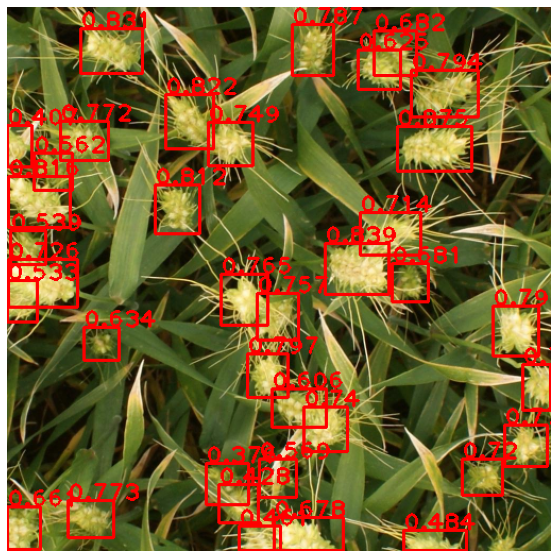

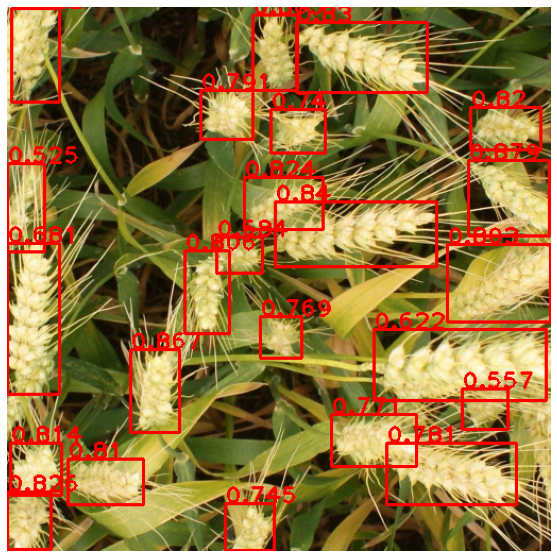

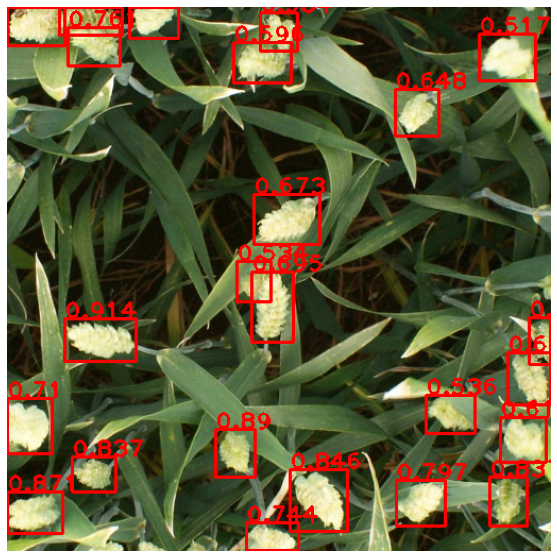

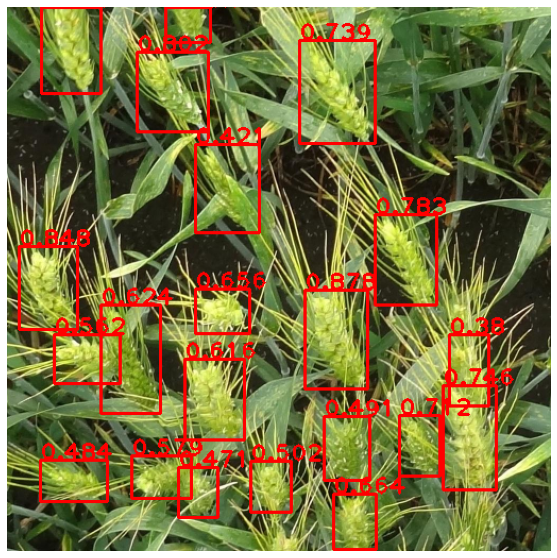

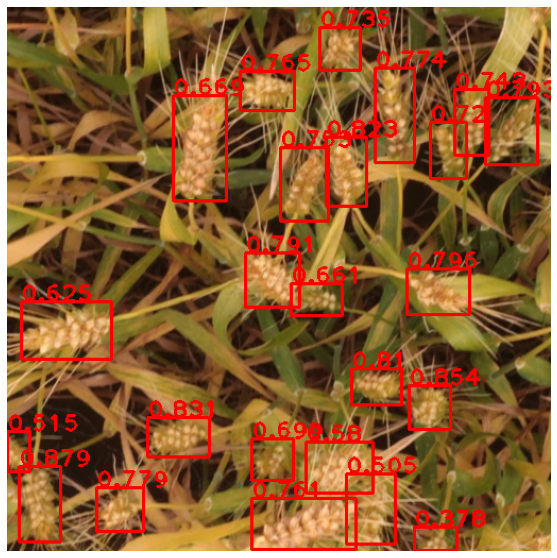

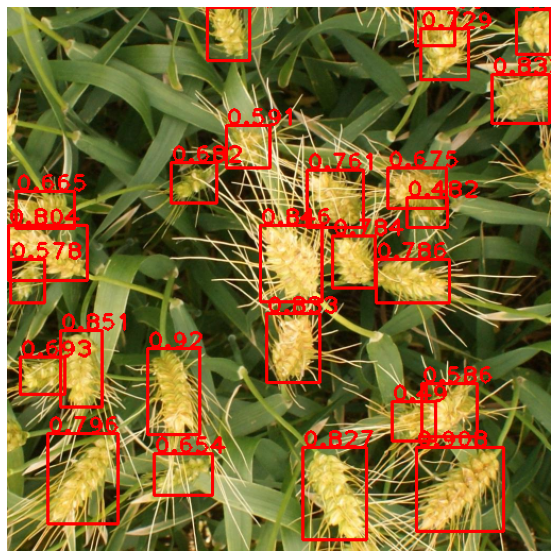

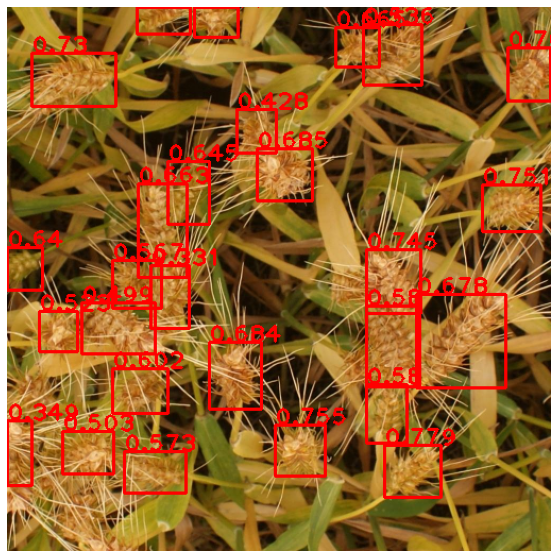

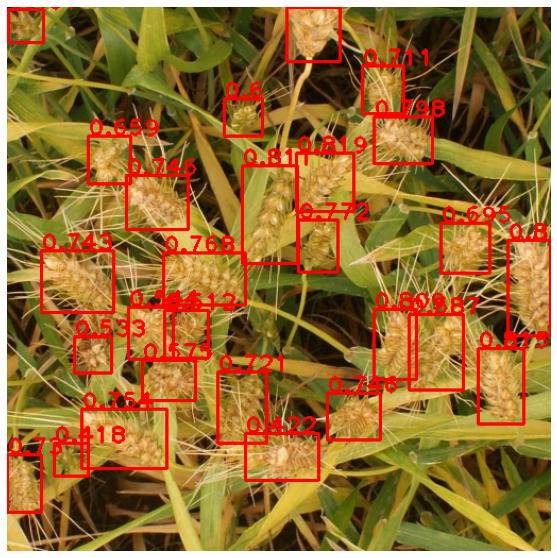

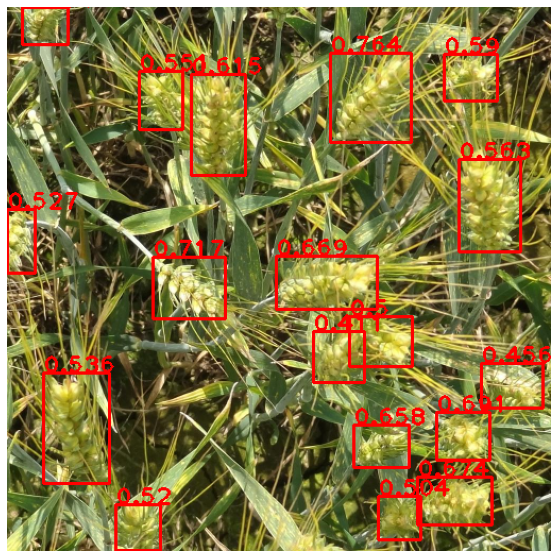

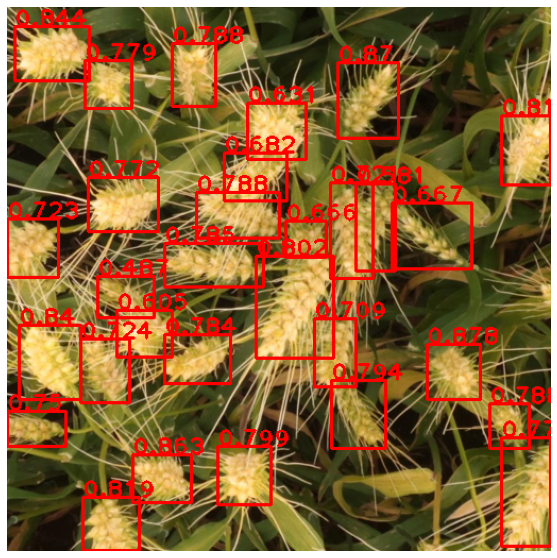

In [ ]:
validation_image_precisions = []
iou_thresholds = [x for x in np.arange(0.5, 0.76, 0.05)]
# model.eval()
# model.to(device)

results = []

for images, image_ids in data_loader:    
    predictions = make_ensemble_predictions(images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i)
        boxes = boxes.astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]

        #plot the images
        sample = images[i].permute(1,2,0).cpu().numpy()
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))

        for j,box in enumerate(boxes):
            cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
            score=str(float("{:.3f}".format(scores[j])))

            cv2.putText(
              sample,
              score,
              org=(int(box[0]), int(box[1] )), # bottom left
              fontFace=cv2.FONT_HERSHEY_PLAIN,
              fontScale=1.5,
              color=(1,0, 0),
              thickness=2
            )
        ax.set_axis_off()
        ax.imshow(sample)
        


        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
        
        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)


In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()